# Step 2-4. LightGBM Modeling
----
### Objective
1. **SageMaker에서 지원하지 않는 알고리즘을 빌드**하여 모델링을 수행합니다. 이를 Bring Your Own Container(BYOC)라고 합니다.
    - 외부 알고리즘에 대한 스크립트, 학습 및 추론 코드를 도커(Docker) 컨테이너로 패키징 후 컨테이터를 Amazon ECR(Elastic Container Registry)로 배포합니다.
    - 도커 컨테이이너 패키징 및 Amzaon ECR 배포는 아래의 예제 패키지를 기반으로 수정하였습니다.
    - https://github.com/awslabs/amazon-sagemaker-examples/tree/master/advanced_functionality/scikit_bring_your_own/container
2. 나머지 과정은 `step2-1-Modeling-XGBoost-HomeCredit-BaselineModel.ipynb`과 동일합니다.

In [1]:
import boto3
import os
import numpy as np
import pandas as pd

s3 = boto3.client('s3')
feature_dir_name = 'modeling-feature-190808'     
bucket = 'analytics-preprocessed-daekeun'    # s3 bucket name
dataset = 'homecredit'
prefix_target = os.path.join(dataset, feature_dir_name)

In [2]:
#get_execution_role 함수는 노트북 인스턴스를 생성할 때 만든 IAM 역할 검색
from sagemaker import get_execution_role
role = get_execution_role()
region = boto3.Session().region_name
print(region)

us-west-2


In [3]:
import sagemaker
from sagemaker.predictor import csv_serializer
from sagemaker.amazon.amazon_estimator import get_image_uri

s3_trn_path = 's3://{}/{}/train.bin'.format(bucket, prefix_target)
s3_val_path = 's3://{}/{}/valid.bin'.format(bucket, prefix_target)
s3_out_path = 's3://{}/{}/output'.format(bucket, dataset)
print([s3_trn_path, s3_val_path, s3_out_path])

['s3://analytics-preprocessed-daekeun/homecredit/modeling-feature-190808/train.bin', 's3://analytics-preprocessed-daekeun/homecredit/modeling-feature-190808/valid.bin', 's3://analytics-preprocessed-daekeun/homecredit/output']


<br>

## 1. Model Training
----
- LightGBM 알고리즘으로 학습을 수행합니다. LightGBM은 최근 Kaggle에서 선풍적인 인기를 얻고 있는 정형 데이터(tabular data)에 강점을 gradient 부스팅 트리 알고리즘입니다. 
- XGBoost에 버금가는 성능 외에 이진 데이터 지원 및 효율적인 계산 알고리즘으로 XGBoost보다 2~5배 빠른 속도를 자랑합니다. 이러한 이유를 간단하게 요약하자면,
    - 의사결정 트리 기반 모형은 각 변수마다 가능한 모든 분할점에 대해 information gain 계산 시에 상당히 오랜 시간이 소요됩니다.
    - LightGBM은 GOSS(Gradient-based One Side Sampling)를 통해 gradient 변화량이 작은 상당 부분들의 데이터 개체들을 제외시키고 EFB(Exclusive Feature Bundling)를 통해 상호 배타적 변수들(다시 말해, 0이 아닌 값들을 동시에 가지는 일이 거의 없는 변수들)을 묶는 방식으로 변수 개수를 줄임으로써, 속도를 획기적으로 개선합니다.
- 자세한 내용 및 각 하이퍼파라메터의 의미는 아래 링크를 참조 바랍니다.
    - https://lightgbm.readthedocs.io/en/latest/
    - https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [4]:
params = dict(
    num_round = 1500,
    learning_rate = 0.01,
    min_data_in_leaf = 30,
    min_split_gain = 0.02,
    max_depth = 6,
    feature_fraction = 0.8,
    bagging_fraction = 0.8,
    objective = 'binary',    
    boosting = 'gbdt', 
    metric = 'auc',
)
metric_definitions = [dict(
    Name = 'auc',
    Regex = '.*\\[[0-9]+\\].*valid_[0-9]+\'s\\sauc: (\\S+)'
)]

In [5]:
sess = sagemaker.Session()
account = sess.boto_session.client('sts').get_caller_identity()['Account']
region = sess.boto_session.region_name

model = sagemaker.estimator.Estimator(
    '{}.dkr.ecr.{}.amazonaws.com/sagemaker-lightgbm:latest'.format(account, region),
    role,
    1, # number of instances
    'ml.c4.2xlarge', 
    output_path=s3_out_path,
    sagemaker_session=sess,
    metric_definitions=metric_definitions
)
 
model.set_hyperparameters(**params)
 
model.fit(dict(
    train = s3_trn_path
))

2019-08-20 04:38:48 Starting - Starting the training job...
2019-08-20 04:38:49 Starting - Launching requested ML instances......
2019-08-20 04:40:18 Downloading - Downloading input data...
2019-08-20 04:40:46 Training - Training image download completed. Training in progress..
Starting the training.
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Starting from the 2.1.2 version, default value for the "boost_from_average" parameter in "binary" objective is true.
This may cause significantly different results comparing to the previous versions of LightGBM.
Try to set boost_from_average=false, 

[251]#011training's auc: 0.775687
[252]#011training's auc: 0.775837
[253]#011training's auc: 0.775938
[254]#011training's auc: 0.776101
[255]#011training's auc: 0.776247
[256]#011training's auc: 0.776383
[257]#011training's auc: 0.776522
[258]#011training's auc: 0.776632
[259]#011training's auc: 0.776741
[260]#011training's auc: 0.776937
[261]#011training's auc: 0.777049
[262]#011training's auc: 0.777171
[263]#011training's auc: 0.77732
[264]#011training's auc: 0.777448
[265]#011training's auc: 0.777548
[266]#011training's auc: 0.777695
[267]#011training's auc: 0.777809
[268]#011training's auc: 0.777937
[269]#011training's auc: 0.778061
[270]#011training's auc: 0.778202
[271]#011training's auc: 0.778354
[272]#011training's auc: 0.778472
[273]#011training's auc: 0.778602
[274]#011training's auc: 0.778736
[275]#011training's auc: 0.778846
[276]#011training's auc: 0.778984
[277]#011training's auc: 0.779115
[278]#011training's auc: 0.779264
[279]#011training's auc: 0.779391
[280]#011traini

[467]#011training's auc: 0.796213
[468]#011training's auc: 0.796276
[469]#011training's auc: 0.796347
[470]#011training's auc: 0.796422
[471]#011training's auc: 0.796487
[472]#011training's auc: 0.796551
[473]#011training's auc: 0.79662
[474]#011training's auc: 0.796681
[475]#011training's auc: 0.796757
[476]#011training's auc: 0.796842
[477]#011training's auc: 0.796906
[478]#011training's auc: 0.796969
[479]#011training's auc: 0.797035
[480]#011training's auc: 0.797102
[481]#011training's auc: 0.797173
[482]#011training's auc: 0.797248
[483]#011training's auc: 0.797316
[484]#011training's auc: 0.797382
[485]#011training's auc: 0.797449
[486]#011training's auc: 0.797513
[487]#011training's auc: 0.797583
[488]#011training's auc: 0.797644
[489]#011training's auc: 0.797712
[490]#011training's auc: 0.797783
[491]#011training's auc: 0.797858
[492]#011training's auc: 0.797934
[493]#011training's auc: 0.798005
[494]#011training's auc: 0.798085
[495]#011training's auc: 0.798151
[496]#011traini

[702]#011training's auc: 0.810522
[703]#011training's auc: 0.810586
[704]#011training's auc: 0.810639
[705]#011training's auc: 0.810678
[706]#011training's auc: 0.810731
[707]#011training's auc: 0.810794
[708]#011training's auc: 0.810848
[709]#011training's auc: 0.810899
[710]#011training's auc: 0.810953
[711]#011training's auc: 0.811007
[712]#011training's auc: 0.811051
[713]#011training's auc: 0.811099
[714]#011training's auc: 0.811153
[715]#011training's auc: 0.811231
[716]#011training's auc: 0.811288
[717]#011training's auc: 0.811337
[718]#011training's auc: 0.811387
[719]#011training's auc: 0.811429
[720]#011training's auc: 0.811481
[721]#011training's auc: 0.811531
[722]#011training's auc: 0.811596
[723]#011training's auc: 0.811656
[724]#011training's auc: 0.811706
[725]#011training's auc: 0.811759
[726]#011training's auc: 0.811806
[727]#011training's auc: 0.811863
[728]#011training's auc: 0.811909
[729]#011training's auc: 0.811961
[730]#011training's auc: 0.812018
[731]#011train

[950]#011training's auc: 0.82227
[951]#011training's auc: 0.822305
[952]#011training's auc: 0.822337
[953]#011training's auc: 0.822376
[954]#011training's auc: 0.822421
[955]#011training's auc: 0.822465
[956]#011training's auc: 0.822521
[957]#011training's auc: 0.822569
[958]#011training's auc: 0.822611
[959]#011training's auc: 0.822664
[960]#011training's auc: 0.82271
[961]#011training's auc: 0.822755
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[962]#011training's auc: 0.822779
[963]#011training's auc: 0.822823
[964]#011training's auc: 0.822863
[965]#011training's auc: 0.822902
[966]#011training's auc: 0.822941
[967]#011training's auc: 0.822987
[968]#011training's auc: 0.823032
[969]#011training's auc: 0.823082
[970]#011training's auc: 0.823119
[971]#011training's auc: 0.823166
[972]#011training's auc: 0.823209
[973]#011training's auc: 0.823251
[974]#011training's auc: 0.823289
[975]#011training's auc: 0.823334
[976]#011training's auc: 0.82337
[977]#011t

[1212]#011training's auc: 0.832623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1213]#011training's auc: 0.832653
[1214]#011training's auc: 0.832686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1215]#011training's auc: 0.832707
[1216]#011training's auc: 0.832737
[1217]#011training's auc: 0.832773
[1218]#011training's auc: 0.832807
[1219]#011training's auc: 0.832845
[1220]#011training's auc: 0.832879
[1221]#011training's auc: 0.832913
[1222]#011training's auc: 0.832945
[1223]#011training's auc: 0.832985
[1224]#011training's auc: 0.833017
[1225]#011training's auc: 0.833046
[1226]#011training's auc: 0.833089
[1227]#011training's auc: 0.833134
[1228]#011training's auc: 0.833179
[1229]#011training's auc: 0.833221
[1230]#011training's auc: 0.833269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1231]#011training's auc: 0.83329
[1232]#011training's auc: 0.833335
[1233]#011training's auc: 0.83337
[1234]#

[1489]#011training's auc: 0.841967
[1490]#011training's auc: 0.841997
[1491]#011training's auc: 0.842028
[1492]#011training's auc: 0.842066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1493]#011training's auc: 0.842097
[1494]#011training's auc: 0.842134
[1495]#011training's auc: 0.842172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1496]#011training's auc: 0.84219
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1497]#011training's auc: 0.842206
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1498]#011training's auc: 0.842229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1499]#011training's auc: 0.842239
[1500]#011training's auc: 0.842267
Training complete.

2019-08-20 04:43:04 Uploading - Uploading generated training model
2019-08-20 04:43:04 Completed - Training job completed
Billable seconds: 166


<br>

## 2. Model Inference in Local
----
- Checkpoint를 생성하여 deploy하기 전에 S3에 저장된 모델을 jupyter notebook이 실행되고 있는 로컬 폴더로 복사하여 prediction을 수행해 봅니다.
- 이 과정을 통해 모델의 성능을 예측할 수 있으며, endpoint로 deploy된 모델과의 비교를 수행할 수 있습니다.
- AUPRC(Area Under Precision Recall Curve)에 대해서는 **`step3-Evaluation.ipynb`**에서 자세히 다룹니다.

In [6]:
%%sh
job_name='sagemaker-lightgbm-2019-08-20-04-38-48-138'
export TRAINING_JOB_NAME=$job_name
export MODEL_ARTIFACT=`aws sagemaker describe-training-job \
--training-job-name $TRAINING_JOB_NAME \
--query ModelArtifacts.S3ModelArtifacts \
--output text`

echo $MODEL_ARTIFACT

aws s3 cp $MODEL_ARTIFACT .
tar xvfz model.tar.gz
rm model.tar.gz

s3://analytics-preprocessed-daekeun/homecredit/output/sagemaker-lightgbm-2019-08-20-04-38-48-138/output/model.tar.gz
download: s3://analytics-preprocessed-daekeun/homecredit/output/sagemaker-lightgbm-2019-08-20-04-38-48-138/output/model.tar.gz to ./model.tar.gz
lightgbm_model.txt


In [7]:
import lightgbm as lgb
import joblib, pickle
model_local = lgb.Booster(model_file='lightgbm_model.txt')
val_data, val_y = joblib.load('trnval/valid.pkl')

confusion matrix (cutoff=0.5)
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56263
           1       0.60      0.04      0.07      4942

   micro avg       0.92      0.92      0.92     61205
   macro avg       0.76      0.52      0.51     61205
weighted avg       0.90      0.92      0.89     61205



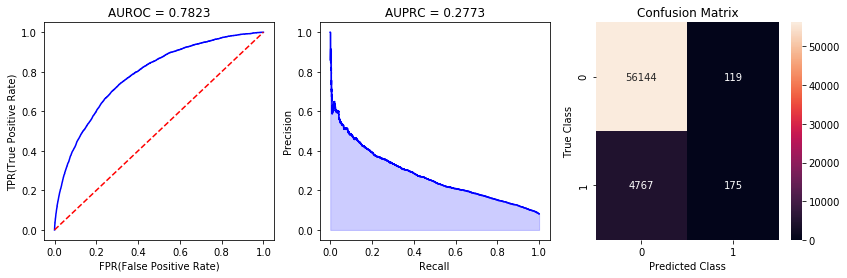

In [8]:
%matplotlib inline
val_y_pred_local = model_local.predict(val_data.values)
from evaluate_fn import evaluate_prediction, get_score_df
evaluate_prediction(val_y.values, val_y_pred_local)

<br>

## 3. Model Deployment to SageMaker Endpoints
----
- 모델을 학습했으므로 실시간 Endpoint에 호스팅되는 모델을 배포합니다.
- 본 데모에서는 SageMaker Python SDK의 `sagemaker.predictor.RealTimePredictor` 객체를 사용하여 검증데이터에 대한 예측을 수행합니다.
- 참조:
    - https://docs.aws.amazon.com/ko_kr/sagemaker/latest/dg/ex1-test-model-endpoint.html
    - https://sagemaker.readthedocs.io/en/stable/predictors.html#sagemaker.predictor.RealTimePredictor

In [9]:
%%time
lgb_predictor = model.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

--------------------------------------------------------------------------------------------------!CPU times: user 392 ms, sys: 25.5 ms, total: 418 ms
Wall time: 8min 15s


In [14]:
%%time   
from sagemaker.predictor import csv_serializer
from evaluate_fn import predict_from_realtime_lgb_predictor

lgb_predictor.content_type = 'text/csv'
lgb_predictor.serializer = csv_serializer
val_y_pred_endpoint = predict_from_realtime_lgb_predictor(val_data.values, lgb_predictor)

CPU times: user 7.68 s, sys: 170 ms, total: 7.85 s
Wall time: 33.4 s


confusion matrix (cutoff=0.5)
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56263
           1       0.60      0.04      0.07      4942

   micro avg       0.92      0.92      0.92     61205
   macro avg       0.76      0.52      0.51     61205
weighted avg       0.90      0.92      0.89     61205



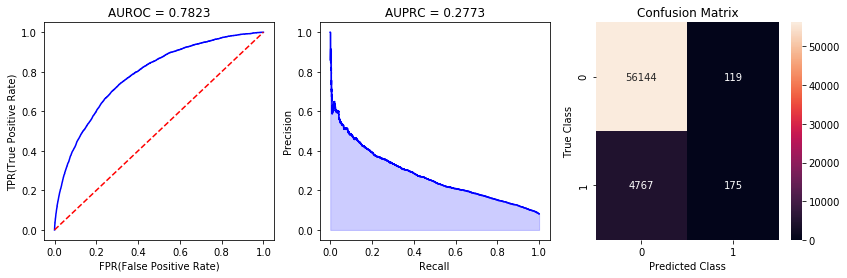

In [15]:
%matplotlib inline
from evaluate_fn import evaluate_prediction, get_score_df
evaluate_prediction(val_y.values, val_y_pred_endpoint)